## 0. Introduction

The aim is to get familiar with **classification problems** and **logistic regression**. 

Dataset -  [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [643]:
!pip install torch

In [644]:
!pip install numpy

In [645]:
!pip install sklearn

In [646]:
!pip install pandas

In [647]:
!pip install seaborn

In [648]:
!pip install scikit-learn

In [649]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

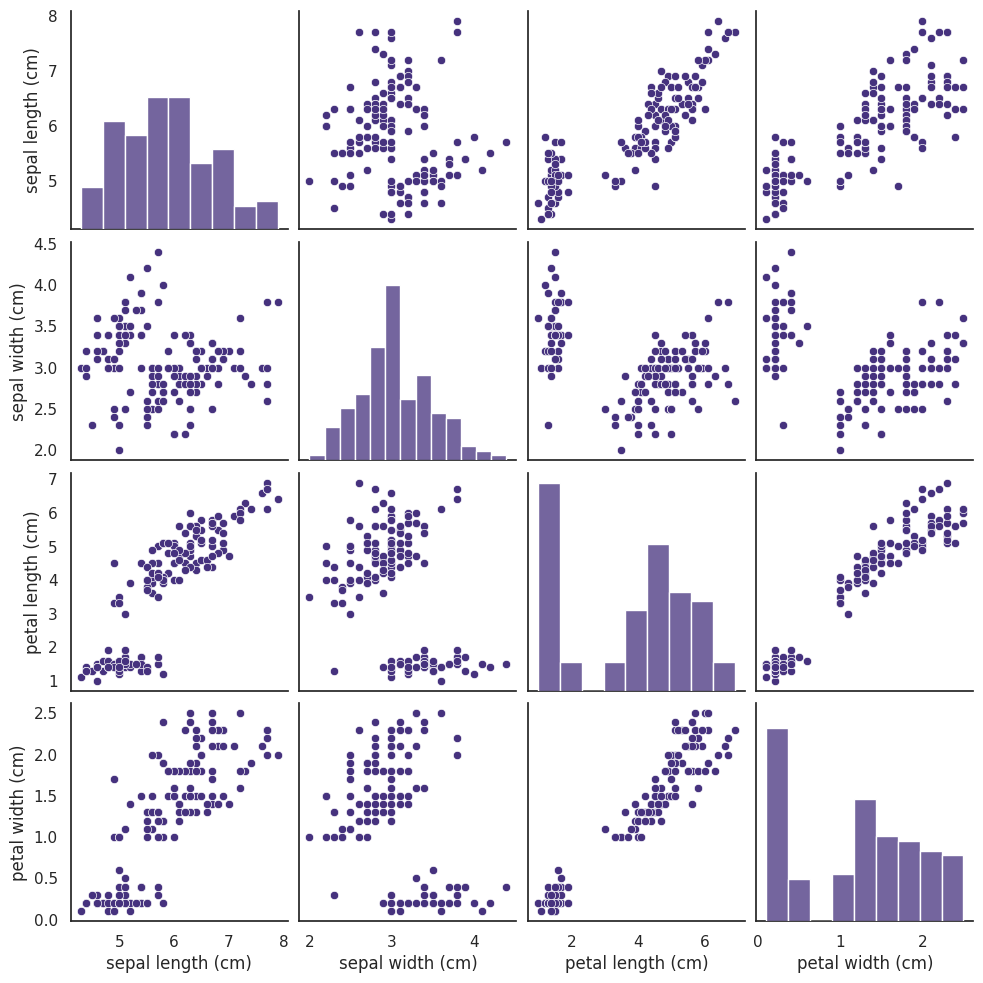

In [650]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)

In [651]:
data_size = iris_db.data.shape

# Print the size
print("Size of Iris dataset (rows, columns):", data_size)

Size of Iris dataset (rows, columns): (150, 4)


In [652]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [653]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

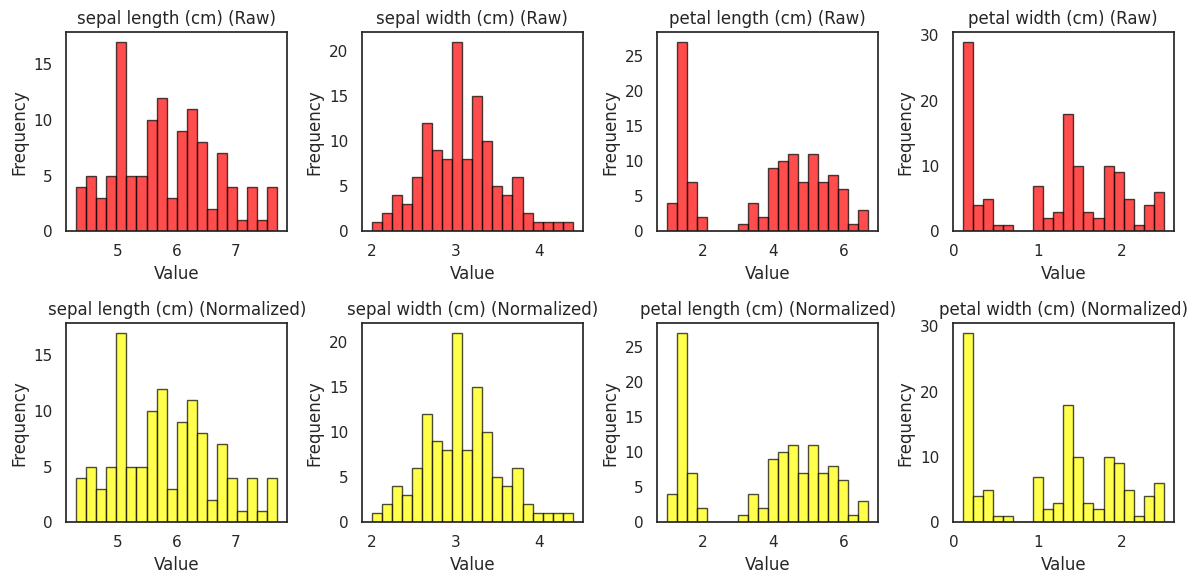

In [654]:
#Normalize sets
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  z = (x - mu)/ sigma
  return z
    
#Calculate mean and std
x_train_mean = x_train.mean(dim=0)
x_train_std = x_train.std(dim=0)

x_train_norm = norm_set(x_train, x_train_mean, x_train_std)
x_test_norm = norm_set(x_test, x_train_mean, x_train_std)


# Plot histograms with feature names
plt.figure(figsize = (12, 6))

#Iterate over features
for i in range(x_train.shape[1]):
    plt.subplot(2, x_train.shape[1], i + 1)
    plt.hist(x_train[:, i], bins = 20, color = 'red', alpha = 0.7, label = 'Raw', edgecolor = 'black')
    plt.title(f'{iris_db.feature_names[i]} (Raw)')
    plt.xlabel('Value')  # Add x-axis label for raw data
    plt.ylabel('Frequency')  # Add y-axis label for raw data
    
    plt.subplot(2, x_train.shape[1], x_train.shape[1] + i + 1)
    plt.hist(x_train[:, i], bins = 20, color = 'yellow', alpha = 0.7, label = 'Normalized', edgecolor = 'black')
    plt.title(f'{iris_db.feature_names[i]} (Normalized)')
    plt.xlabel('Value')  # Add x-axis label for normalized data
    plt.ylabel('Frequency')  # Add y-axis label for normalized data
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

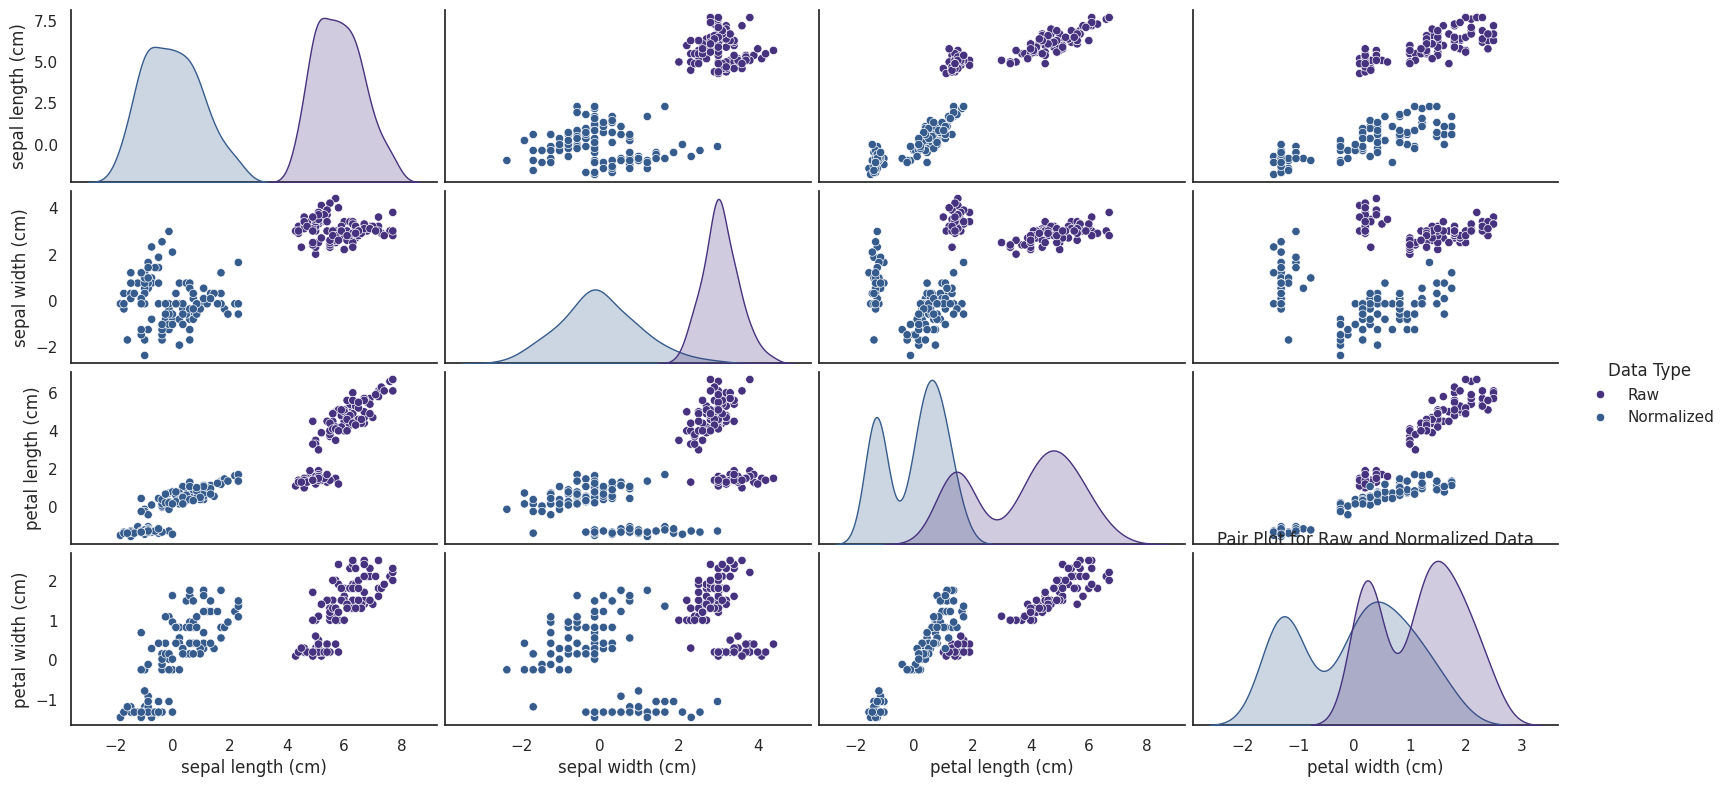

In [655]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#Create DataFrames for raw and normalized data
x_train_df = pd.DataFrame(x_train.numpy(), columns=iris_db.feature_names)
x_train_norm_df = pd.DataFrame(x_train_norm.numpy(), columns=iris_db.feature_names)

#Add a column to indicate whether the data is raw or normalized
x_train_df['Data Type'] = 'Raw'
x_train_norm_df['Data Type'] = 'Normalized'

#Concatenate the DataFrames
combined_df = pd.concat([x_train_df, x_train_norm_df], ignore_index=True)

#Set the default color palette
sns.set(style="white", palette="viridis")

#Plot pairplot for both raw and normalized data
plt.figure(figsize=(15, 8))

sns.pairplot(combined_df, hue = 'Data Type', height = 2, aspect = 2)
plt.title("Pair Plot for Raw and Normalized Data")
plt.show()


In [656]:
print(x_train.shape)
print(x_test.shape)

torch.Size([120, 4])
torch.Size([30, 4])


By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

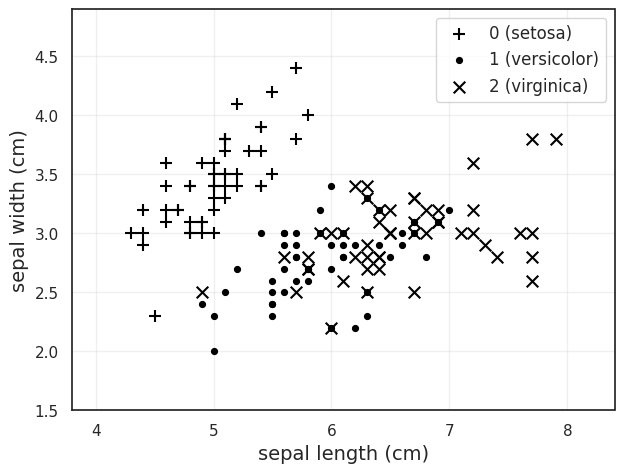

In [657]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?

The data appears to be slightly separable, between class 0 (labeled '+') and the other classes. But it is not perfectly linear separable as there is some overlap between the classes. We cannot draw straight lines between the data to completely separate points in different classes.

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [658]:
train_set_1 = x_train[:, :2]
test_set_1 = x_test[:, :2]

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

In [659]:
print(test_set_1.shape)

torch.Size([30, 3])


In [660]:
print(setosa_test.shape)

torch.Size([30, 1])


## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $



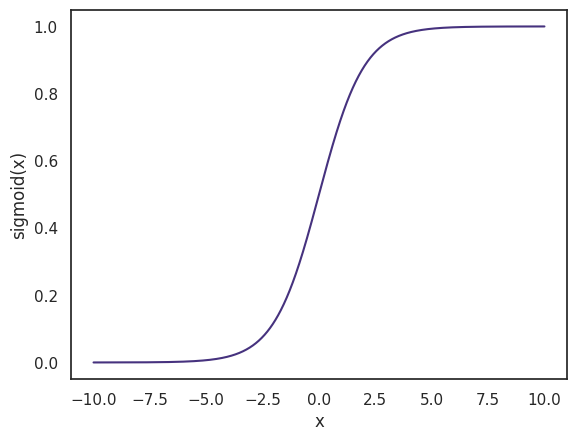

In [661]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  ### your code here
  z = 1 / (1 + torch.exp(-z))  
  return z


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
#Adding label
ax1.set_xlabel('x')
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [662]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    y = 0
    ### your code here
    #Calculate the linear transformation
    linear_output = torch.mm(x, self.weight.T)
        
    # Apply the sigmoid activation function
    y = torch.sigmoid(linear_output)
    return y

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$



In [663]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  ### your code here
  m = y_true.size(0)  # number of examples
  binary_cross_entropy_loss = 1/m * ( torch.sum(- (y_true * torch.log(y_pred)) - ((1 - y_true) * torch.log(1 - y_pred)), dim=0) )
  return binary_cross_entropy_loss
  


def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  ### your code here
  #Calculate partial derivative of the loss function with respect to w
  partial_derivative = torch.sum((y_pred - y) * X, dim=0)

  #Update the weights vector using the gradient descent equation
  weight = weight - lr * partial_derivative  
  model.weight = nn.Parameter(weight, requires_grad=False)

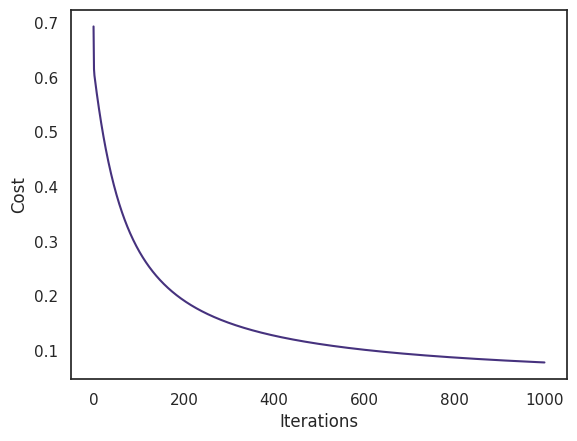

Parameter containing:
tensor([[-3.1461,  5.0996,  0.8471]])
Minimum cost: [0.07869527]


In [664]:
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output

def train(model, x, y, alpha):
    cost_lst = list()
    for it in range(1000):
        prediction = model(x)
        cost = bce(y, prediction)  
        cost_lst.append(cost) 
        gradient_descent_step(model, x, y, prediction, alpha)

    clear_output(wait=True)
    cost_lst = torch.stack(cost_lst).detach().numpy()
    plt.plot(list(range(it+1)), cost_lst)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.show()
    print(model.weight)
    print('Minimum cost: {}'.format(min(cost_lst)))

# Assuming LogisticRegression, train_set_1, setosa_train, bce, and gradient_descent_step are defined

model = LogisticRegression(train_set_1.shape[1])
# alpha = 1 # select an appropriate lr
alpha = 0.001# select an appropriate lr
train(model, train_set_1, setosa_train, alpha)

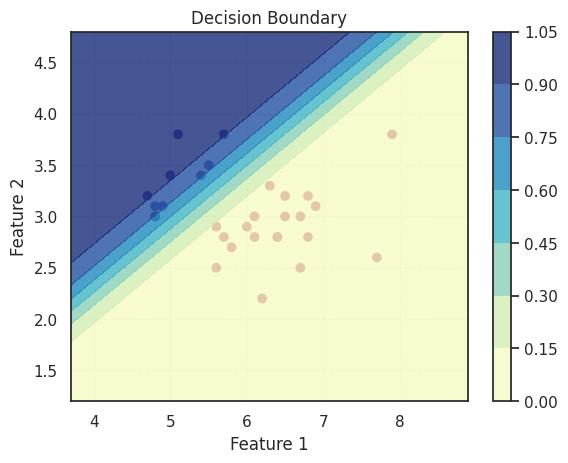

In [665]:
### your code here

import numpy as np

def plot_decision_boundary(model, X, y):
    w = model.weight.detach().numpy()

    #Plotting the data points with first two features
    first = X[:, 0]
    second = X[:, 1]
    plt.scatter(first, second, c = y, cmap = plt.cm.Spectral)

    #Create decision boundary
    x_min, x_max = first.min() - 1, first.max() + 1
    y_min, y_max = second.min() - 1, second.max() + 1
    
    #Create a meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    #Calculating the output for all points in the meshgrid
    all_points = torch.tensor(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])]).float()
    Z = model(all_points)
    Z = Z.reshape(xx.shape)
    #Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap = plt.cm.YlGnBu, alpha = 0.8)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.colorbar()
    #Adding grid
    plt.grid(True, linestyle = '--', alpha = 0.4)
    plt.show()

plot_decision_boundary(model, test_set_1, setosa_test)

## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [666]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape)

torch.Size([30, 3])


In this section we will use the built in pytorch methods.


In [667]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


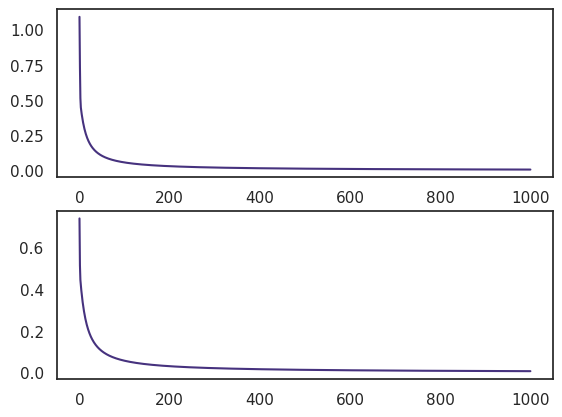

Minimum train cost: 0.007408162113279104
Minimum test cost: 0.007103194482624531


In [668]:
train(setosa_model, x_train, setosa_labels, x_test, setosa_testy, optimiser, alpha)

In [669]:
print(iris_db.target_names)

['setosa' 'versicolor' 'virginica']


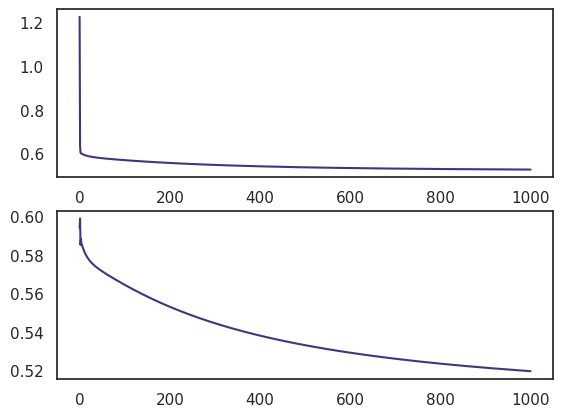

Minimum train cost: 0.527090311050415
Minimum test cost: 0.5196726322174072


In [670]:
### your code here
#Training classifiers for Versicolor class

versicolor_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()
optimiser_versicolor = optim.SGD(versicolor_model.parameters(), alpha)

train(versicolor_model, x_train, versicolor_labels, x_test, versicolor_testy, optimiser_versicolor, alpha)

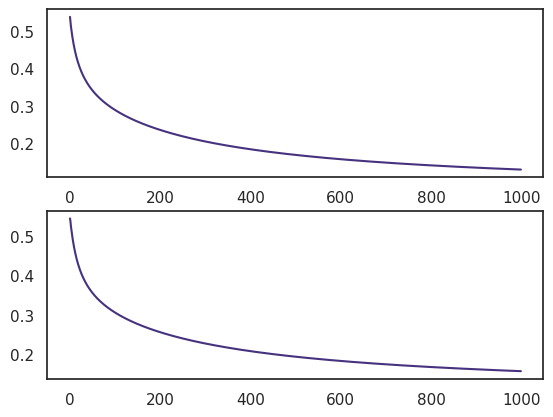

Minimum train cost: 0.13045400381088257
Minimum test cost: 0.15728120505809784


In [671]:
#Training classifiers for virginica class
virginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
virginica_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_testy = y_test[:, 2].reshape(-1, 1).float()
optimiser_virginica = optim.SGD(virginica_model.parameters(), alpha)

train(virginica_model, x_train, virginica_labels, x_test, virginica_testy, optimiser_virginica, alpha)


In [672]:
### your code here
#Predict the class with the highest probability using 3 classifiers
def predict_classifier(setosa_model, versicolor_model, virginica_model, x):
    #Setting model to eval mode
    setosa_model.eval()
    versicolor_model.eval()
    virginica_model.eval()

    #Calculate probability using each classifier for every class
    setosa_pred = setosa_model(x)
    versicolor_pred = versicolor_model(x)
    virginica_pred = virginica_model(x)

    #Concatenate predictions of each classifier
    concatenate_pred = torch.cat([setosa_pred, versicolor_pred, virginica_pred], dim=1)  
    return concatenate_pred


prediction_df = pd.DataFrame(concatenate_pred.detach().numpy(), columns=iris_db.target_names)
test_df = pd.DataFrame(x_test.numpy())
result_df = pd.concat([test_df, prediction_df], axis=1)
styled_result_df = result_df.style.set_caption('<b>Predictions on Test Set</b>')

In [673]:
styled_result_df

,0,1,2,3,setosa,versicolor,virginica
0,6.100000,2.800000,4.700000,1.200000,0.001930,0.555446,0.204866
1,5.700000,3.800000,1.700000,0.300000,0.993570,0.131685,0.000000
2,7.700000,2.600000,6.900000,2.300000,0.000002,0.788148,0.995355
3,6.000000,2.900000,4.500000,1.500000,0.002875,0.372811,0.227103
4,6.800000,2.800000,4.800000,1.400000,0.001542,0.642776,0.102629
5,5.400000,3.400000,1.500000,0.400000,0.989457,0.165684,0.000001
6,5.600000,2.900000,3.600000,1.300000,0.036559,0.282165,0.022363
7,6.900000,3.100000,5.100000,2.300000,0.000483,0.276589,0.567543
8,6.200000,2.200000,4.500000,1.500000,0.000727,0.717342,0.427614
9,5.800000,2.700000,3.900000,1.200000,0.012897,0.462247,0.042896


In [674]:
from IPython.display import display
#Convert the actual answers to dataframe
y_test_dataframe = pd.DataFrame(y_test.detach().numpy(),columns=iris_db.target_names)
#Convert test set to dataframe
test_dataframe = pd.DataFrame(x_test.numpy())

#Concatenating both the dataframes
actual_result_df = pd.concat([test_dataframe, y_test_dataframe], axis  =1)
actual_result_df = actual_result_df.style.set_caption('<b>Actual Answers</b>')
display(actual_result_df)#Printing dataframe

,0,1,2,3,setosa,versicolor,virginica
0,6.100000,2.800000,4.700000,1.200000,0,1,0
1,5.700000,3.800000,1.700000,0.300000,1,0,0
2,7.700000,2.600000,6.900000,2.300000,0,0,1
3,6.000000,2.900000,4.500000,1.500000,0,1,0
4,6.800000,2.800000,4.800000,1.400000,0,1,0
5,5.400000,3.400000,1.500000,0.400000,1,0,0
6,5.600000,2.900000,3.600000,1.300000,0,1,0
7,6.900000,3.100000,5.100000,2.300000,0,0,1
8,6.200000,2.200000,4.500000,1.500000,0,1,0
9,5.800000,2.700000,3.900000,1.200000,0,1,0


In [675]:
print(concatenate_pred.shape)
print(y_test.shape)

print(concatenate_pred[0])
print(y_test[0])

print("The shape of pred: ", concatenate_pred.shape)
print("The shape of y_test: ", y_test.shape)

print("Sample of pred: ", concatenate_pred[0])
print("Sample of y_test: ", y_test[0])

torch.Size([30, 3])
torch.Size([30, 3])
tensor([0.0019, 0.5554, 0.2049], grad_fn=<SelectBackward0>)
tensor([0, 1, 0])
The shape of pred:  torch.Size([30, 3])
The shape of y_test:  torch.Size([30, 3])
Sample of pred:  tensor([0.0019, 0.5554, 0.2049], grad_fn=<SelectBackward0>)
Sample of y_test:  tensor([0, 1, 0])


In [676]:
pred_probabilities = F.softmax(concatenate_pred, dim=1)
pred_probabilities = concatenate_pred

class_names = ['Setosa', 'Versicolor', 'Virginica']

# Get the class with the highest probability for each sample indicating species from the probability of multi class column
pred_classes = torch.argmax(pred_probabilities, dim=1)
predicted_class_names = [class_names[idx] for idx in pred_classes]

print("Sample of pred_class: ", pred_classes[0])
# y_pred_classes = torch.tensor(y_test, dtype=torch.long)
y_test_classes = torch.argmax(y_test, dim=1)
true_class_names = [class_names[idx] for idx in y_test_classes]
print("Sample of y_pred_class: ", y_test_classes[0])

print("predicted classes (0,1 or 2): ", pred_classes)
print("actual classes: (0,1 or 2)", y_test_classes)

print("All predicted class names: ", predicted_class_names)
print("All true class names: ", true_class_names)

Sample of pred_class:  tensor(1)
Sample of y_pred_class:  tensor(1)
predicted classes (0,1 or 2):  tensor([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 0, 0])
actual classes: (0,1 or 2) tensor([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 0, 0])
All predicted class names:  ['Versicolor', 'Setosa', 'Virginica', 'Versicolor', 'Versicolor', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor', 'Versicolor', 'Virginica', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor', 'Versicolor', 'Virginica', 'Setosa', 'Virginica', 'Setosa', 'Virginica', 'Virginica', 'Virginica', 'Virginica', 'Virginica', 'Setosa', 'Setosa']
All true class names:  ['Versicolor', 'Setosa', 'Virginica', 'Versicolor', 'Versicolor', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor', 'Versicolor', 'Virginica', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor', 'Versicolor', 

In [677]:
result_df = result_df.assign(predicted_class=predicted_class_names)
result_df = result_df.assign(true_class=true_class_names)

result_df.to_csv('result.csv', index=False)

In [678]:
# Get total number of correct predictions
correct_predictions = (pred_classes == y_test_classes).sum().item()

total_samples = len(y_test)
# Calculate Accuracy
accuracy = correct_predictions / total_samples

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Accuracy on the test set: 100.00%


## 3. The XOR problem




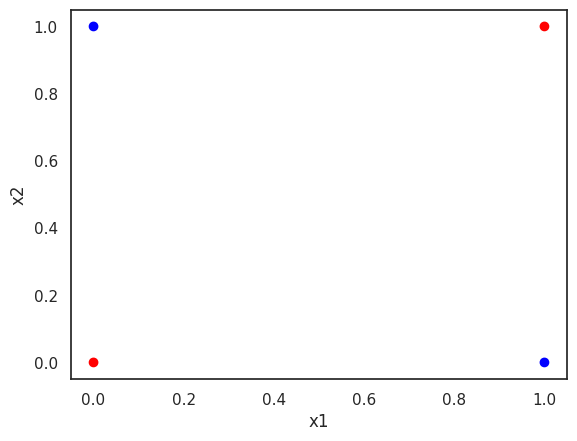

In [679]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()